In [ ]:
!pip install pip install umap-learn
!pip install pytorch-lightning
import tarfile
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import umap
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib
font = {'weight' : 'regular',
        'size'   : 22}

matplotlib.rc('font', **font)

In [ ]:
!curl -O https://gist.githubusercontent.com/jszym/479db2af32411b64249bfb1bff43a95e/raw/1bef32b78e6ddd414beebe6e57cf3b0a0fac44ea/dictlogger.py
from dictlogger import DictLogger

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1610  100  1610    0     0   5532      0 --:--:-- --:--:-- --:--:--  5532


# ECSE552 - W22 - Homework 3
Released: 11 March 2023

Due: 30 March 2023

Last Modified: 11 March 2023

---

For questions please contact:


Part 1 - Joseph Szymborski (`joseph.szymborski@mail.mcgill.ca`)

Part 2 - David Hostallero (`david.hostallero@mail.mcgill.ca`)

---

### Group 9:
- Gauri Sharma
- Kevin Kong

# Part 1 - Conditional Variational Autoencoders

### Introduction

Conditional Variational Autoencoders (CVAEs) are an extension of Variational Autoencoders (VAEs).

As we explored in tutorial eight, VAEs are comprised of two main parts: an encoder and a decoder.

The encoder approximates the function $Q(z|X)$ and the decoder approximates the function $P(X|z)$.

As a reminder, here $X$ is the input data and $z$ is a latent vector.

For more details, you might consider this [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908) by Carl Doersch.

The above formulation, however, does not allow us to generate specific images. For example, given a model trained on the MNIST digits, it's difficult to fully explore the latent space for a given digit.

We can solve this by conditioning $P$ by not only the latent vector $z$, but some value $c$ that can encode information, (_e.g._: which MNIST digit we're generating).

This would mean our decoder would got from $P(X|z)$ in the VAE case to $P(X|z,c)$ in the CVAE case.

### Practical Implementation

Practically, this means that a "conditional" vector $c$ is passed to the decoder. This is commonly a class label for the sample that is one-hot encoded, but it can be anything you wish to marginalise the model by.

Below is a very high-level illustration of both a Variational Autoencoder (VAE) and a Conditional Variational Autoencoder (CVAE). Components of the CVAE that are not present in the VAE are demarked with a yellow star.

The CVAE is identical to the VAE, but for the concatenation of the vector $c$ to the vector $z$ before being inputted into the decoder. The loss function does not change in any way.

In this diagram the dimensions are noted for all the inputs and outputs of the Encoder and Decoder.

The dimension variables are as follows:

* $m$ is the batch size
* $w$ is the width of the image inputted into our encoder
* $h$ is the height of the image inputted into our encoder
* $n$ is the number of latent variables
* $q$ is the width of the conditional vector. If $c$ represents the class of the image, then $q$ is often equal to the number of classes.

![VAE vs CVAE](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/vae_cvae.webp)

Let's look closer at the concatenation of $z$ and $c$, as well as the representation of $c$. Consider the case of a CVAE where the samples are MNIST digits and $c$ is the one-hot encoded class of the digit. In this example, the number of latent variables ($n$ in the diagram above) is 3. Below is an illustration of what the concatenation might look like.

![Concatenating z with c](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/conditional_z.webp)

The vectors that are the result of concatenating $z$ and $c$ (let's call it $z_c$) then become the input to the decoder.

### Q1.1 - Implementing an MNIST CVAE (26 pts)

Your task is to extend the MNIST VAE from Tutorial 8 to a CVAE.

Specifically, you must:

1. Correctly define a conditional vector $c$ in the training loop.
2. Correctly concatenate it to $z$ to form $z_c$.
3. Input $z_c$ to the Decoder.
4. Make any further nescessary modifications to the code.

You are provided with the complete code for the MNIST VAE presented in Tutorial 8, including data loaders, encoders, decoders, and training/validation loops.

The number of latent variables for this excercise ($n$) is set to 10.

**Hint**: While you are permitted to make changes to the Encoder and Decoder class, it is not nescessary to correctly answer this question.

**Another Hint**: You can correctly answer this question by modifying/adding no more than six lines.

In [ ]:
class MNISTDataset(Dataset):

    def __init__(self, csv_path):

        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        return torch.tensor(self.df.iloc[idx][1:])/255, self.df.iloc[idx][0]

In [ ]:
batch_size = 100

dataset = MNISTDataset('./sample_data/mnist_train_small.csv')

num_test = len(dataset) // 10
num_train = len(dataset) - num_test
dataset_train, dataset_test = random_split(dataset, [num_train, num_test])

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super(Encoder, self).__init__()

        self.layer0 = nn.Linear(in_dim, 1024)
        self.layer1 = nn.Linear(512, 768)
        self.layer2 = nn.Linear(768, 1024)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(128, latent_dim)

        self.pool = nn.MaxPool1d(2)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):

        x = self.layer0(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer1(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer2(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer3(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer4(x)
        x = self.activation(x)

        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super(Decoder, self).__init__()

        self.layer4 = nn.Linear(784, out_dim)
        self.layer3 = nn.Linear(768, 784)
        self.layer2 = nn.Linear(1024, 768)
        self.layer1 = nn.Linear(256, 1024)
        self.layer0 = nn.Linear(latent_dim, 256)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):

        x = self.layer0(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer1(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer2(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer3(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer4(x)
        x = torch.sigmoid(x)

        return x

In [ ]:
class MNIST_VAE(pl.LightningModule):
    def __init__(self, in_dim, out_dim, latent_dim, c_dim):
        super(MNIST_VAE, self).__init__()

        self.latent_dim = latent_dim
        self.c_dim = c_dim
        
        self.encoder = Encoder(in_dim, latent_dim*2)

        # Chsnge the input dim of decoder
        self.decoder = Decoder(latent_dim+c_dim, out_dim)
        self.recon_criterion = nn.BCELoss(reduction='sum')

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) 

    def loss(self, mu, logvar, pred, target):

        kld_loss = torch.sum(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        recons_loss = self.recon_criterion(pred, target)

        loss = recons_loss + kld_loss

        return kld_loss, recons_loss, loss

    def forward(self, x, y):

        parameters= self.encoder(x)

        mu = parameters[:, :self.latent_dim]
        logvar = parameters[:, self.latent_dim:]

        z = self.reparameterize(mu, logvar)
        
        # Define c and z_c here
        c = torch.zeros(z.size()[0], self.c_dim).type_as(z)
        for i, row in enumerate(c):
            row[y[i]] = 1.0
        z_c = torch.cat((z, c), 1)

        x_hat = self.decoder(z_c)

        return mu, logvar, z, x_hat

    def training_step(self, batch, batch_idx):

        x, y = batch
        
        mu, logvar, z, x_hat = self(x, y)

        kld_loss, recons_loss, loss = self.loss(mu, logvar, x_hat, x)

        self.log('training_loss', loss, on_step=False, on_epoch=True)
        self.log('training_kld_loss', kld_loss, on_step=False, on_epoch=True)
        self.log('training_recons_loss', recons_loss, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):

        x, y = batch

        mu, logvar, z, x_hat = self(x, y)

        kld_loss, recons_loss, loss = self.loss(mu, logvar, x_hat, x)

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_kld_loss', kld_loss, on_step=False, on_epoch=True)
        self.log('val_recons_loss', recons_loss, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(dataloader_train), epochs=20)
        return [optimizer], [scheduler]

In [ ]:
model = MNIST_VAE(784,784,10,10)

In [ ]:
logger = DictLogger()
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, 
                               patience=3)

trainer = pl.Trainer(logger=logger, callbacks=[early_stopping],
                     max_epochs=40)


trainer.fit(model, dataloader_train, dataloader_test)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/DictLogger/0.1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type    | Params
--------------------------------------------
0 | encoder         | Encoder | 2.1 M 
1 | decoder         | Decoder | 2.3 M 
2 | recon_criterion | BCELoss | 0     
--------------------------------------------
4.4 M     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 20510.293


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1337.514 >= min_delta = 0.0001. New best score: 19172.779


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1614.479 >= min_delta = 0.0001. New best score: 17558.301


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 684.322 >= min_delta = 0.0001. New best score: 16873.979


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 402.713 >= min_delta = 0.0001. New best score: 16471.266


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 184.576 >= min_delta = 0.0001. New best score: 16286.689


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 329.374 >= min_delta = 0.0001. New best score: 15957.315


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 140.649 >= min_delta = 0.0001. New best score: 15816.666


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 65.580 >= min_delta = 0.0001. New best score: 15751.086


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 290.146 >= min_delta = 0.0001. New best score: 15460.940


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 269.754 >= min_delta = 0.0001. New best score: 15191.187


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 250.113 >= min_delta = 0.0001. New best score: 14941.073


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 188.655 >= min_delta = 0.0001. New best score: 14752.418


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 203.497 >= min_delta = 0.0001. New best score: 14548.921


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 66.438 >= min_delta = 0.0001. New best score: 14482.482


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 171.902 >= min_delta = 0.0001. New best score: 14310.580


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 79.095 >= min_delta = 0.0001. New best score: 14231.485


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 45.088 >= min_delta = 0.0001. New best score: 14186.397


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 45.398 >= min_delta = 0.0001. New best score: 14140.999


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 4.608 >= min_delta = 0.0001. New best score: 14136.391


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 26.221 >= min_delta = 0.0001. New best score: 14110.170


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 72.325 >= min_delta = 0.0001. New best score: 14037.845


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 18.125 >= min_delta = 0.0001. New best score: 14019.720


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 14019.720. Signaling Trainer to stop.


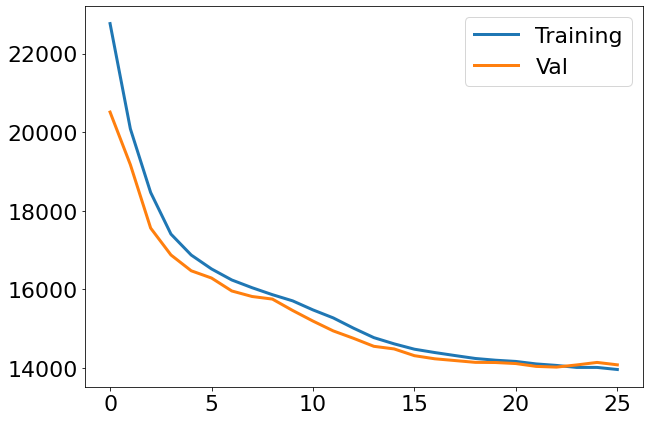

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(logger.metrics['training_loss'], label='Training', lw=3)
plt.plot(logger.metrics['val_loss'], label='Val', lw=3)
plt.legend()
plt.show()

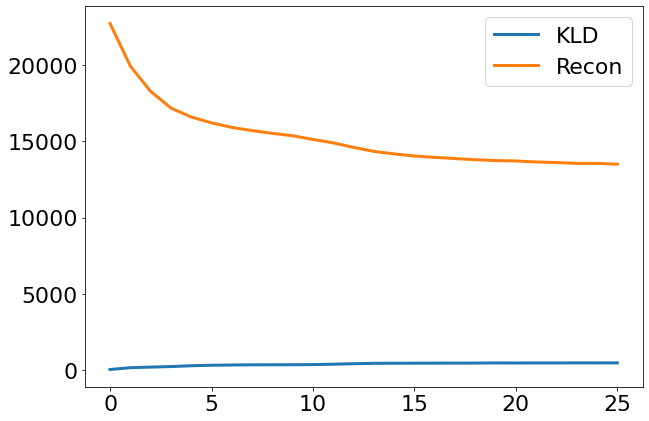

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(logger.metrics['training_kld_loss'], label='KLD', lw=3)
plt.plot(logger.metrics['training_recons_loss'], label='Recon', lw=3)
plt.legend()
plt.show()

### Q1.2 Demonstrate Reconstruction (11 pts)

In the same way as was demonstrated in Tutorial 8, the ability of your model to reconstruct the first two digits from the first batch provided by `dataloader_test`. 

Specifically, pass the first two values of `x` and `y` from `dataloader_test` to `model` and reconstruct these images. Plot them as illustrated below:

![Reconstructed MNIST digits](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/q1.2.webp)

**Note**: The batches are randomised so you won't nescessarily get the same samples shown above.

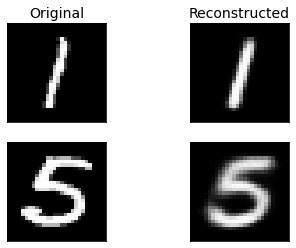

In [ ]:
# Q1.2 Code Here
batch = iter(dataloader_test)
(x, y) = next(batch)

x = x.view(-1,28*28)
test_out = model(x, y)

mu, logvar, z, x_hat = test_out

fig, ax = plt.subplots(2,2)

for i in range (0,2):
  for j in range (0,2):
    ax[i, j].xaxis.set_ticks([])
    ax[i, j].yaxis.set_ticks([])

ax[0, 0].set_title('Original', fontsize=14)
ax[0, 0].imshow(x[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[0, 1].set_title('Reconstructed', fontsize=14)
ax[0, 1].imshow(x_hat[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

ax[1, 0].imshow(x[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[1, 1].imshow(x_hat[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

### Q1.3 Demonstrate Conditional Reconstruction (13 pts)

Similar to Q1.2, reconstruct digits, but instead of using the correct $c$ vector, change the class label to a different one.

For example, the value of `y` for the two samples below are 3 and 6, but when reconstructing, the $c$ vector `[0,0,1,0,0,0,0,0,0,0]` was supplied.

![Conditioned Reconstruction](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/q1.3.png)

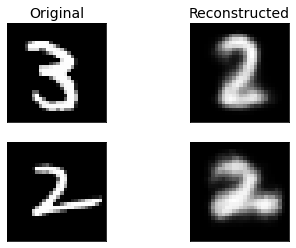

In [96]:
# Q1.3 Code Here
batch = iter(dataloader_test)
(x, y) = next(batch)

x = x.view(-1,28*28)
test_out = model(x, (y-y+2)%10)

mu, logvar, z, x_hat = test_out

fig, ax = plt.subplots(2,2)

for i in range (0,2):
  for j in range (0,2):
    ax[i, j].xaxis.set_ticks([])
    ax[i, j].yaxis.set_ticks([])

ax[0, 0].set_title('Original', fontsize=14)
ax[0, 0].imshow(x[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[0, 1].set_title('Reconstructed', fontsize=14)
ax[0, 1].imshow(x_hat[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

ax[1, 0].imshow(x[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[1, 1].imshow(x_hat[5].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

### Q1.4 Explore the Latent Space (26 pts)

We now wish to traverse the latent space by individually sweeping each latent variable within a standard deviation. By doing so with a fixed value of $c$, we can better understand what individual latent variables encode for with regard to a specific digit.

Specifically, your task is to:

1. Calculate the mean ($\mu$) of latent vectors `z` from one batch provided by `dataloader_test`
2. Calculate the stdev ($\sigma$) of latent vectors `z` from one batch provided by `dataloader_test`
3. For each combination of $i \in [1\dots n]$ and $j \in [1\dots10]$:
    1. Create a [clone](https://pytorch.org/docs/stable/generated/torch.Tensor.clone.html#torch.Tensor.clone) of the $\mu$ vector named $z^{*(i,j)}$
    2. Calculate $\delta = \frac{(\mu+2\sigma) - (\mu - 2\sigma)}{9}$
    3. Make the $i$th element of $z^{*(i,j)}$ equal to $\mu_i-2\sigma_i + \delta_i \times j$ 
    4. Input into our model's decoder the latent vector $z^{*(i,j)}$ 
  and a $c$ vector that encodes for the number 2 to create an image $\hat{x}^{*(i,j)}$
4. Plot every $\hat{x}^{*(i,j)}$ in a $10\times10$ grid, where each row is a different value of $i$, and each column is a different value of $j$

Recall, $n$ is the number of latent variables.

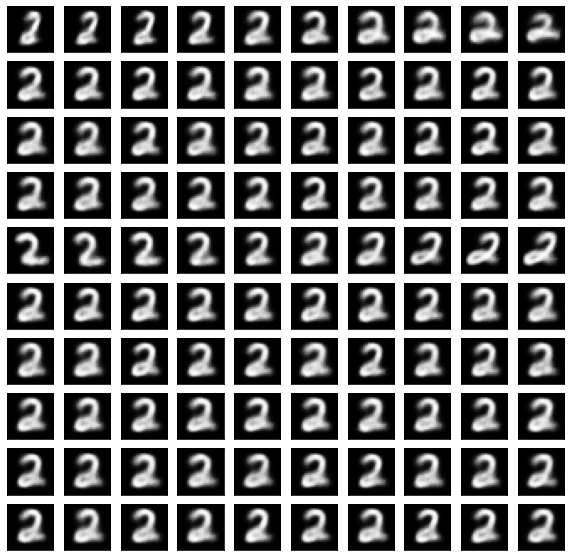

In [ ]:
# Q1.4 Code Here
batch = iter(dataloader_test)
(x, y) = next(batch)

x = x.view(-1,28*28)
test_out = model(x, y)

mu, logvar, z, x_hat = test_out

# Choose the number 2
c = torch.zeros(10)
c[2] = 1.0
# Calculate mu and std
mu = torch.mean(z, dim=0).detach().numpy()
std = torch.std(z, dim=0).detach().numpy()
# Calculate delta
delta = ((mu + 2*std) - (mu - 2*std))/9

fig, ax = plt.subplots(10,10,figsize=(10,10))
for i in range (0,10):
  for j in range (0,10):
    ax[i, j].xaxis.set_ticks([])
    ax[i, j].yaxis.set_ticks([])

for idx_i in range(0, 10):
    # Create a clone of mu
    z_ij = mu.copy()
    for idx_j in range(0, 10):  
        z_ij[idx_i] = mu[idx_i] - 2*std[idx_i] + delta[idx_i]*idx_j
        z_c = torch.cat((torch.Tensor(z_ij), c), 0)
        x_ij = model.decoder(z_c)
        ax[idx_i, idx_j].imshow(x_ij.reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

## Part 2: Graph Convolution Networks (GCN)

The node update equation for a Graph Convolution layer is given by

$$
\begin{align}
h_u^{(l+1)} = \sigma(b^{(l)} + \sum_{v \in N(u)}\frac{1}{c_{u,v}} W^{(l)}h^{(l)}_v),
\end{align}
$$

where $u$ is the node, $l$ is the layer, $b$ is the bias, and $W$ is the trainable parameter matrix. Here, $h^{(0)}$ is the node feature.

A 2D Convolution layer without kernel flipping is given by

$$
\begin{align}
S^{(l+1)}(i, j) &= \sigma((S^{(l)}*K^{(l)})(i,j) + b^{(l)})\\
 &= \sigma(\sum_m \sum_n S^{(l)}(i+m,j+n) K^{(l)}(m,n) + b^{(l)}),
\end{align}
$$

where $S$ is the feature map, and $K$ is the kernel. Here $S^{(0)}=I$ (*i.e.* original image).

*Hint:* For simplicity, set the biases to 0.

### Q2.1: Describe a graph that is equivalent to an image (6 pts)
Include \textbf{all} the details and technicalities (*e.g.*, which components are equivalent, node connectivity, edge cases, exceptions, indexing). An illustration could help but grading will be solely based on the description. Anything that is part of the illustration that is not described in words will not count as a point. This will be the base graph to be used in your solution for Q2.2 and Q2.3. 

### A2.1: 
To create a graph equivalent to an image, we can construct a graph with nodes representing each pixel in the image and edges capturing the neighborhood relationship between pixels. Here are the details and technicalities:

<li>Nodes: For an image of size MxN, create MxN nodes in the graph. Each node is represented by a tuple (i, j), where i denotes the row index and j denotes the column index of the pixel in the image. The node feature, $h^{(0)}_{(i,j)}$, corresponds to the intensity value (for grayscale) or color channels (for RGB) of the pixel at position (i, j).</li>

<li>Edges: Connect each node with its adjacent neighbors to establish the neighborhood relationship. For each pixel (i, j), create edges between the pixel and its 8 neighboring pixels (i-1, j-1), (i-1, j), (i-1, j+1), (i, j-1), (i, j+1), (i+1, j-1), (i+1, j), and (i+1, j+1), assuming they are within the image boundaries. This results in a grid-like graph structure.</li>

<li>Edge cases: For pixels on the image boundaries (i.e., top, bottom, left, and right edges), the number of neighboring pixels will be less than 8. For example, the top-left corner pixel (0, 0) will only have 3 neighbors: (0, 1), (1, 0), and (1, 1). Similarly, the bottom-right corner pixel (M-1, N-1) will have 3 neighbors: (M-2, N-1), (M-1, N-2), and (M-2, N-2). Other edge pixels will have 5 neighbors each.</li>

<li>Indexing: Index the nodes in the graph based on their pixel positions in the image. For example, use a row-major or column-major ordering. Row-major ordering would map node (i, j) to index i * N + j, while column-major ordering would map it to j * M + i.</li>

<li>Normalization: For the Graph Convolution Network, we can include normalization by setting $c_{u,v} = \sqrt{deg(u)deg(v)}$, where $deg(u)$ and $deg(v)$ are the degrees of nodes u and v, respectively. This helps account for the varying degrees of nodes in the graph, especially for the edge and corner cases.</li>

By creating a graph as described above, we can establish an equivalent representation of an image that captures the spatial relationship between pixels and can be used as input for a Graph Convolution Network.

### Q2.2: Assuming that there is no 2D pooling, under which conditions are GraphConv and 2DConv equivalent? (10 pts)

We are looking for hyperparameters, graph properties, and kernel properties. Show your reasoning. You can setup a constraint for some elements to be equal for the CNN and GCN, or equal to a specific values. 

*Hint:* Fix kernel size to a specific size then work on that solution.

### A2.2:
To make GraphConv (GCN) and 2DConv (CNN) equivalent under the assumption that there is no 2D pooling, we need to ensure that certain hyperparameters, graph properties, and kernel properties are the same or have specific values. We'll use a fixed kernel size (e.g., 3x3) for this analysis:

<b> GraphConv (GCN) Layer:</b>

The node update equation for a GraphConv layer is given by:

\begin{equation*}
h_u^{(l+1)} = \sigma(b^{(l)} + \sum_{v \in N(u)}\frac{1}{c_{u,v}} W^{(l)}h^{(l)}_v)
\end{equation*}

where the inputs and outputs are of shape $(N, \texttt{in\_channels})$ and $(N, \texttt{out\_channels})$, respectively. The GCN layer has trainable parameters $W^{(l)}$ and biases $b^{(l)}$.

<b>2DConv (CNN) Layer without Kernel flipping:</b>

The 2D Convolution layer without kernel flipping is given by:

\begin{equation*}
S^{(l+1)}(i, j) = \sigma((S^{(l)}*K^{(l)})(i,j) + b^{(l)}) = \sigma(\sum_m \sum_n S^{(l)}(i+m,j+n) K^{(l)}(m,n) + b^{(l)})
\end{equation*}

where the inputs and outputs are of shape $(\texttt{batch\_size}, \texttt{in\_channels}, \texttt{height}, \texttt{width})$ and $(\texttt{batch\_size}, \texttt{out\_channels}, \texttt{out\_height}, \texttt{out\_width})$, respectively. The 2DConv layer has trainable kernels $K^{(l)}$ and biases $b^{(l)}$.

To make the outputs of the GCN and 2DConv equivalent, we need to satisfy the following conditions:
<li>The graph structure should represent the local connectivity of the image pixels.</li>
<li>Set the biases $b^{(l)}$ in both GCN and CNN layers to 0.</li>
<li>The activation functions $\sigma$ in both GCN and CNN layers should be the same.</li>
<li>The weight matrix $W^{(l)}$ in the GCN should correspond to the kernel $K^{(l)}$ in the CNN. Specifically, fixed kernel size of 3x3 for the CNN. We can consider a 1-layer GCN with a 3x3 local neighborhood connectivity, which means that for each node, the GCN layer aggregates information from its eight surrounding neighbors and itself.</li>
<li>The normalization constant $c_{u,v}$ in the GCN should be set to 1, which means that the graph is not normalized.</li>


Under these conditions, the GCN and 2DConv without pooling will produce equivalent outputs. The GCN should have an output where each of the $\texttt{out\_height}*\texttt{out\_width}$ nodes has an embedding vector of length $\texttt{out\_channels}$, and the nodes/axes can be arranged such that the values will be exactly equal to that of the 2DConv.




By satisfying these conditions, we can establish that the GraphConv (GCN) and the 2DConv (CNN) are equivalent, as they will have the same connectivity patterns, weight sharing properties, normalization, and activation functions.

### Q2.3: Assuming that there is a 2D pooling after the 2D convolution, under which conditions are GraphConv and 2DConv+2DPool equivalent? (9 pts)

We are looking for hyperparameters, graph properties, and kernel properties. Show your reasoning. You can setup a constraint for some elements to be equal for the CNN and GCN, or equal to a specific values. Do not forget to specify the type of pooling.

*Hint:* The activation function $\sigma$ is a hyperparameter that you can constrain.

### A2.3:

To make GraphConv (GCN) and 2DConv+2DPool (CNN with pooling) equivalent, we need to ensure that certain hyperparameters, graph properties, and kernel properties are the same or have specific values. We'll use a fixed kernel size (e.g., 3x3) and 2x2 max pooling for this analysis:

<b> GraphConv (GCN) Layer:</b>

The node update equation for a GraphConv layer is given by:

\begin{equation*}
h_u^{(l+1)} = \sigma(b^{(l)} + \sum_{v \in N(u)}\frac{1}{c_{u,v}} W^{(l)}h^{(l)}_v)
\end{equation*}

where the inputs and outputs are of shape $(N, \texttt{in\_channels})$ and $(N, \texttt{out\_channels})$, respectively. The GCN layer has trainable parameters $W^{(l)}$ and biases $b^{(l)}$.

<b>2DConv (CNN) Layer:</b>

The 2D Convolution layer without kernel flipping is given by:

\begin{equation*}
S^{(l+1)}(i, j) = \sigma((S^{(l)}*K^{(l)})(i,j) + b^{(l)}) = \sigma(\sum_m \sum_n S^{(l)}(i+m,j+n) K^{(l)}(m,n) + b^{(l)})
\end{equation*}

where the inputs and outputs are of shape $(\texttt{batch\_size}, \texttt{in\_channels}, \texttt{height}, \texttt{width})$ and $(\texttt{batch\_size}, \texttt{out\_channels}, \texttt{out\_height}, \texttt{out\_width})$, respectively. The 2DConv layer has trainable kernels $K^{(l)}$ and biases $b^{(l)}$.

<b> 2D Pooling (CNN) Layer: </b>

The 2D max pooling operation is given by:

\begin{equation}
P^{(l+1)}(i, j) = \max_{m=0}^{1}\max_{n=0}^{1} S^{(l+1)}(2i + m, 2j + n)
\end{equation}

where $P^{(l+1)}$ is the pooled feature map, and we assume a 2x2 max pooling operation without overlapping.

Now, to make GraphConv and 2DConv+2DPool equivalent, we need to satisfy the following conditions:

<li> Set the biases $b^{(l)}$ in both GCN and CNN layers to 0.</li>
<li> Use the identity activation function $\sigma(x) = x$ in both GCN and CNN layers.</li>

Under these conditions, the GCN update equation becomes:

\begin{equation}
h_u^{(l+1)} = \sum_{v \in N(u)}\frac{1}{c_{u,v}} W^{(l)}h^{(l)}_v,
\end{equation}

and the CNN update equation becomes:

\begin{equation}
S^{(l+1)}(i, j) = \sum_m \sum_n S^{(l)}(i+m,j+n) K^{(l)}(m,n),
\end{equation}

To make these equivalent, we must ensure that:
<li>The weight matrix $W^{(l)}$ in the GCN corresponds to the kernel $K^{(l)}$ in the CNN.</li>
<li>The graph structure represents the local connectivity of the image pixels (as described in the previous answer).</li>
<li> Normalization in the GCN should be applied using the inverse square root of the product of the degrees of the connected nodes, i.e., $c_{u,v} = \sqrt{deg(u)deg(v)}$. </li>

Finally, to make the pooling operation in GCN equivalent to the 2D max pooling in CNN, we must apply Graph Pooling with max pooling as the aggregation function, as described in the previous answer.

With these conditions met, the GraphConv and 2DConv+2DPool are equivalent.











### Clarifications 

Q2.2 and Q2.3 pertain to the conditions in which the outputs of the 1-layer GCN is equivalent to the outputs of the 2DConv/2DConv+2DPool.

Let the output of the 2DConv/2DConv+2DPool have the dimensions $(\texttt{out_channels} \times \texttt{out_height} \times \texttt{out_width})$. The GCN should have an output where each of the $\texttt{out_height}*\texttt{out_width}$ nodes has an embedding vector of length $\texttt{out_channels}$, and the nodes/axes can be arranged sucht that the values will be *exactly* equal to that of the 2DConv/2DConv+2DPool.

Look up the documentation for `torch.nn.Conv2d` and `dgl.nn.pytorch.conv.GraphConv` to see which properties need defining in Q2.2 and Q2.3. We will assume the "defaults" for unspecified properties.

*JSYK:* There may be multiple solutions to this problem. You do not need a "generalizable" solution, but we will find loopholes so it is safer to define/constrain all possible properties that could "break" your solution. Our hints only pertain to one specific solution. However, setting all parameters to zero/infinity does not count towards earning points.